# Data Description

## Data Source

* PUBG Match Deaths and Statistics, Kaggle 
    \- https://www.kaggle.com/skihikingkevin/pubg-match-deaths

## Data Introduction

In this Kaggle Dataset, over 720,000 competitive matches from the popular game PlayerUnknown's Battlegrounds. The data was extracted from pubg.op.gg, a game tracker website.


### PlayerUnknown's Battlegrounds

PUBG is a first/third-person shooter battle royale style game that matches over 90 players on a large island where teams and players fight to the death until one remains. Players are airdropped from an airplane onto the island where they are to scavenge towns and buildings for weapons, ammo, armor and first-aid. Players will then decide to either fight or hide with the ultimate goal of being the last one standing. A bluezone (see below) will appear a few minutes into the game to corral players closer and closer together by dealing damage to anyone that stands within the bluezone and sparing whoever is within the safe zone.


### The Dataset

This dataset provides two zips: aggregate and deaths.

In **deaths**, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In **aggregate**, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.
The uncompressed data is divided into 5 chunks of approximately 2gb each.

### Columns in deaths

1. killed_by: Which weapon is killed
1. killer_name: Killer game id
1. killer_placement: The final ranking of the team where the killer is located
1. killer_position_x: X coordinate of the killer when the killing behavior occurs
1. killer_position_y: Y coordinate of the killer when the killing behavior occurs
1. map: Game Map(Erangel island/ Miramar desert)
1. match_id : Event Unique ID
1. time: When the kill occurs(How many seconds after the game starts)
1. victim_name: The killed game id
1. victim_position_x: X coordinate of the person being killed when the killing occurs
1. victim_position_y: Y coordinate of the killer at the time of the killing behavior

### Columns in aggregate

1. date: Start time of the game
1. game_size: Site size
1. match_id: Event Unique ID
1. match_mode: Game Mode(First/ Third Person View)
1. party_size: Squad size(1person/ 2people/ 4people)
1. player_assists: Rescue teammates
1. player_dbno: Number of times the player was knocked down
1. player_dist_ride: Driving Distance
1. player_dist_walk: Walking distance
1. player_dmg: Injury points
1. player_kills: kills
1. player_name: Player Game id
1. player_survive_time: Player survival time
1. team_id: The player's team number
1. team_placement: The final ranking of the player's team

# 라이브러리 및 데이터 로드

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
tqdm.pandas()
import os

In [204]:
# MAC 기준
# Window font: 'Malgun Gothic'

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 데이터

In [ ]:
data_dir = '../dataset/raw/'

In [ ]:
def data_load(data_dir, name_list, df_list):
    df_list = []
    for i in tqdm(name_list):
        df_list.append(pd.read_csv(data_dir + i))
    return df_list

In [ ]:
agg_data_dir = '../dataset/raw/aggregate/'
agg_name_list = sorted(os.listdir(agg_data_dir))
agg_list = []
agg_list = data_load(agg_data_dir, agg_name_list, agg_list)

In [ ]:
deaths_data_dir = '../dataset/raw/deaths/'
deaths_name_list = sorted(os.listdir(deaths_data_dir))
deaths_list = []
deaths_list = data_load(deaths_data_dir, deaths_name_list, deaths_list)

In [ ]:
def get_shape(df_list):
    for i in df_list:
        print(i.shape)

In [ ]:
get_shape(agg_list)

In [ ]:
get_shape(deaths_list)

# Data preprocessing

## Aggregate의 na 제거

In [ ]:
def df_drop_na(df_list):
    for i in tqdm(range(len(df_list))):
        df_list[i] = df_list[i].dropna()

In [ ]:
df_drop_na(agg_list)

## match_mode 제거
* 모두 'tpp'만 가짐

In [ ]:
def del_col(df_list, col_name):
    for i in tqdm(df_list):
        del i[col_name]

In [ ]:
del_col(agg_list, 'match_mode')

## 두 데이터에서 매칭되지 않는 match_id 제거

In [ ]:
def get_unique_match_id(df_list):
    match_id = []
    for i in df_list:
        match_id += [x for x in i['match_id'].unique()]
    return match_id

In [ ]:
agg_match_id = get_unique_match_id(agg_list)

In [ ]:
len(agg_match_id)

In [ ]:
deaths_match_id = get_unique_match_id(deaths_list)

In [ ]:
agg_mat = set(agg_match_id)
deaths_mat = set(deaths_match_id)

In [ ]:
len(agg_mat), len(deaths_mat), len(agg_mat & deaths_mat)

In [ ]:
get_shape(deaths_list)

In [ ]:
for i in range(len(deaths_list)):
    deaths_list[i] = deaths_list[i][deaths_list[i]['match_id'].isin(agg_match_id)]

In [ ]:
get_shape(deaths_list)

## deaths data na 처리

### map na 처리

In [ ]:
deaths_list[0]['map'].unique()

* map 결측값 대체 가능 여부 확인

In [ ]:
map_na_match_id = []
for i in deaths_list:
    map_na_match_id += [x for x in i.loc[i['map'].isnull(), 'match_id'].unique()]

In [ ]:
E_match_id = []
for i in deaths_list:
    E_match_id += [x for x in i.loc[i['map'] == 'ERANGEL', 'match_id'].unique()]

In [ ]:
M_match_id = []
for i in deaths_list:
    M_match_id += [x for x in i.loc[i['map'] == 'MIRAMAR', 'match_id'].unique()]

* 겹치는 match_id 확인

In [ ]:
map_na_match_id = set(map_na_match_id)
E_match_id = set(E_match_id)
M_match_id = set(M_match_id)

In [ ]:
len(map_na_match_id & E_match_id), len(map_na_match_id & M_match_id), len(E_match_id & M_match_id) 

* 대체 불가능 판단 -> Drop

In [ ]:
get_shape(deaths_list)

### deaths 데이터 na drop

In [ ]:
df_drop_na(deaths_list)

In [ ]:
get_shape(deaths_list)

## Data 병합

* key columns
    * agg.match_id = deaths.match_id
    * agg.player_name = deaths.killer_name

In [ ]:
# key column의 이름을 맞춰야 함
# deaths의 killer_name을 player_name으로 변경

def chg_col_names(df_list, col_names):
    for i in tqdm(df_list):
        i.columns = col_names

In [ ]:
deaths_list[0].columns

In [ ]:
deaths_cols = ['killed_by', 'player_name', 'killer_placement', 'killer_position_x',
               'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
               'victim_placement', 'victim_position_x', 'victim_position_y']

In [ ]:
# key column 이름 맞추기

chg_col_names(deaths_list, deaths_cols)

## Aggregate 데이터와 Deaths 데이터 Merge

* 같은 번호의 데이터와 짝을 이루는 것을 match_id로 확인함
    * e.g. agg_0는 deaths_0과 Merge

In [ ]:
get_shape(agg_list)

In [ ]:
get_shape(deaths_list)

In [ ]:
deaths_list[0]['map'].unique()

In [ ]:
def get_merged_df(left, right, join, keys):
    df_list = []
    for i in tqdm(range(len(left))):
        df_list.append(pd.merge(left[i], right[i], how=join, on=keys))
    return df_list

In [ ]:
df_merge = get_merged_df(agg_list, deaths_list, 'left', ['match_id', 'player_name'])

In [ ]:
get_shape(df_merge)

## map 채우기

In [ ]:
def fill_map_na(df_list, match_id_list, map_name):
    for i in df_list:
        i.loc[(i['match_id'].isin(match_id_list))&(i['map'].isnull()), 'map'] = map_name
    return df_list

In [ ]:
match_id = [E_match_id, M_match_id]
map_names = ['ERANGEL', 'MIRAMAR']

for i in tqdm(range(len(match_id))):
    df_merge = fill_map_na(df_merge, match_id[i], map_names[i])

## map별로 데이터 나누기

* ERANGEL과 MIRAMAR로 데이터 셋을 나눔

In [ ]:
def get_df_map(df_list, map_name):
    df_map = []
    for i in df_list:
        df_map.append(i[i['map'] == map_name])
    return df_map

In [ ]:
df_map  = []
for i in tqdm(range(len(map_names))):
    df_map.append(get_df_map(df_merge, map_names[i]))

## party_size 별로 데이터 나누기

* party_size에 따라 Tier가 다르기 때문에 데이터를 분리함

In [ ]:
def get_df_party_size(df_list, party_size):
    df_party_size = []
    for i in df_list:
        df_party_size.append(i[i['party_size'] == party_size])
    return df_party_size

In [ ]:
df = []
party_size = [1, 2, 4]

for i in tqdm(range(len(party_size))):
    for j in range(len(df_map)):
        df.append(get_df_party_size(df_map[j], party_size[i]))

In [ ]:
# df[0]: solo, ERANGEL / df[1]: solo, MIRAMAR
# df[2]: duo, ERANGEL / df[3]: duo, MIRAMAR
# df[4]: squad, ERANGEL / df[5]: squad, MIRAMAR

len(df)

## party_size별 map별 dataset 합치기

In [ ]:
def get_concat(df_list):
    df_concat = []
    for i in tqdm(range(len(df_list))):
        df_concat.append(pd.concat(df_list[i], ignore_index=True))
    return df_concat

In [ ]:
# df_concat[0]: solo, ERANGEL / df_concat[1]: solo, MIRAMAR
# df_concat[2]: duo, ERANGEL / df_concat[3]: duo, MIRAMAR
# df_concat[4]: squad, ERANGEL / df_concat[5]: squad, MIRAMAR

df_concat = get_concat(df)

## killed_by 그룹핑

In [ ]:
def killed_by_refine(df):
    df['killed_by'] = df['killed_by'].replace({'death.WeapSawnoff_C': 'sawed_off', 
                                               'death.PlayerMale_A_C': 'Punch',
                                               'death.PG117_A_01_C': 'Boat' , 'death.RedZoneBomb_C': 'RedZone'})
    df['killed_by'] = df['killed_by'].replace(['Pickup Truck','Hit by Car','Buggy','Dacia','Motorbike',
                                               'Motorbike (SideCar)','Uaz','Van'], 'land_vehicle')
    df['killed_by'] = df['killed_by'].replace(['death.ProjMolotov_C', 'death.ProjMolotov_DamageField_C', 
                                               'death.Buff_FireDOT_C'], 'Molotov')
    df['killed_by'] = df['killed_by'].replace(['Aquarail','Boat'], 'water_vehicle')

In [ ]:
for i in tqdm(df_concat):
    killed_by_refine(i)

## csv로 내보내기

In [ ]:
def df_read_csv(df_list, data_dir, file_name):
    for i in tqdm(range(len(df_list))):
        df_list[i].to_csv(data_dir + f'{file_name[i]}.csv', index=False)

# Bug player 처리

In [ ]:
data_dir = '../dataset/preprocessing/'

df = pd.read_csv(data_dir + 'squad_E.csv')

In [ ]:
df_raw = df.copy()

In [ ]:
class CheckingBugPlayer:
    
    '''
    Bug Player 처리를 위한 Class 입니다.
    아래의 기준 중 하나라도 만족하는 player는 Bug player로 지정합니다.
    
    dist_ride : 30000(30km) 초과
    dist_walk : 10000(10km) 초과
    kills :     30 kill 초과
    dmg :       3000 damage 초과
    kill_dist : 40000(400m) 초과
    dbno :      11 초과
    survive_time : 1900 초과
    
    '''
    
        
    def player_dist_ride(self, df):
        df.loc[df['player_dist_ride'] > 30000, 'outlier'] = 1
        return df
    
    def player_dist_walk(self, df):
        df.loc[df['player_dist_walk'] > 10000, 'outlier'] = 1
        return df
        
    def player_kills(self, df):
        df.loc[df['player_kills'] > 30, 'outlier'] = 1
        return df
    
    def player_dmg(self, df):
        df.loc[df['player_dmg'] > 3000, 'outlier'] = 1 
        return df
        
    def kill_dist(self, df):
        df['kill_dist'] = np.sqrt(((df['killer_position_x'] - df['victim_position_x']) ** 2) 
                                      + ((df['killer_position_y'] - df['victim_position_y']) ** 2))
        df['kill_dist'] = df['kill_dist'].fillna(0)
        df.loc[df['kill_dist'] > 40000, 'outlier'] = 1
        return df    
    
    def player_dbno(self, df):
        df.loc[df['player_dbno'] > 11, 'outlier'] = 1
        return df
    
    def player_survive_time(self, df):
        df.loc[df['player_survive_time'] > 1900, 'outlier'] = 1
        return df


## Bug player 처리

In [ ]:
checker = CheckingBugPlayer()

df = checker.player_dist_ride(df)
df = checker.player_dist_walk(df)
df = checker.player_kills(df)
df = checker.player_dmg(df)
df = checker.kill_dist(df)
df = checker.player_dbno(df)
df = checker.player_survive_time(df)

df['outlier'] = df['outlier'].fillna(0)

In [ ]:
df['outlier'].value_counts()

## 분석 Dataset 확인

In [ ]:
df.describe()

In [ ]:
df_outlier = df.copy()

# 파생변수 생성 1

In [ ]:
class DerivingVariables:
    
    '''
    파생변수를 만드는 Class 입니다.
    아래의 방법으로 파생변수를 생성하였습니다.
    
    date         : dtype을 datetime 으로 변환
    score        : (rank_point * 1) + (kill * 2) + (assist * 2)
    tier         : score column을 바탕으로 구함. squad의 +0.6은 위치를 맞추기 위한 수평이동
    KDA          : kill, assist, death를 이용해 파생변수 생성 
                   death는 match 합계에서 team_placement가 1등인 횟수를 제외하여 계산
    num_of_match : player별 총 게임 횟수를 계산
    
    '''
    
    def date(self, df):
        df.loc[:, 'date'] = pd.to_datetime(df['date'])
        return df
    
    def score(self, df):
        max_team_placement = df.groupby(['date', 'match_id'])['team_placement'].max().reset_index()
        max_team_placement.columns = ['date', 'match_id', 'max_placement']
        df = pd.merge(df, max_team_placement, how='left', on=['date', 'match_id'])
        
        df['each_game_score'] = (df['max_placement'] - df['team_placement'])*0.1 + np.log(df['player_dmg'] + 1) + df['player_dbno']*(-0.1)
        
        # score의 sum 
        each_score = df.groupby(['player_name', 'date', 'match_id'])['each_game_score'].mean().to_frame()
        total_score = each_score.groupby('player_name')['each_game_score'].sum().to_frame()
        total_score.columns = ['total_score']
        df['total_score'] = total_score.loc[df['player_name'], 'total_score'].values
        
        return df
    
    def kda_num_of_match(self, df):
        # 필요한 column 만 추출
        anal_col = df[['player_name', 'match_id','team_placement', 'player_kills', 'player_assists']]

        # num_of_match
        num_of_match = anal_col.groupby('player_name')['match_id'].nunique().reset_index()
        num_of_match.columns = ['player_name', 'num_of_match']

        # num_of_1st
        num_of_1st = anal_col[anal_col['team_placement'] == 1].groupby('player_name')['match_id'].nunique().reset_index()
        num_of_1st.columns = ['player_name', 'num_of_1st']

        # death 
        temp = num_of_match.merge(num_of_1st, how = 'left', on = 'player_name')
        temp = temp.fillna(0)
        temp.loc[:, 'deaths_sum'] = temp['num_of_match'] - temp['num_of_1st']
        death = temp[['player_name', 'deaths_sum']]

        # kill & assist
        KA_count = anal_col.groupby(['player_name', 'match_id'])[['player_kills', 'player_assists']].mean().reset_index()
        KA_sum = KA_count.groupby('player_name')[['player_kills', 'player_assists']].sum().reset_index()
        KA_sum.columns = ['player_name', 'kills_sum', 'assists_sum']

        # KDA
        KDA = KA_sum.merge(death, how = 'left', on = 'player_name')
        KDA.loc[:, 'kda'] = (KDA['kills_sum'] + KDA['assists_sum']) / KDA['deaths_sum']
        KDA_1 = KDA[['player_name', 'kda']]


        ## 여기 한번에 표현 할 수 있는가
        df = df.merge(KDA_1, how='left', on='player_name')
        df = df.merge(num_of_match, how='left', on='player_name' )

        return df

## 파생변수1 생성

In [ ]:
variables = DerivingVariables()

df = variables.date(df)

In [ ]:
df = variables.score(df)

In [ ]:
df = variables.kda_num_of_match(df)

In [ ]:
df_var1 = df.copy()

# 파생변수 생성 2

In [ ]:
class DerivingVariables2:
    """
    
    
    """
    
    def date_vars(self, df):
        df['kor_date'] = df['date'] + datetime.timedelta(hours=9)
        df['day_of_week'] = df['kor_date'].dt.weekday
        df['weekend'] = [1 if x >= 6 else 0 for x in df['day_of_week'] ]
        df['date_time'] = df['kor_date'].dt.hour

        def get_time_zone(time):
            if time <= 4 :
                return 'peak time'
            elif time <= 10 :
                return 'morning'
            elif time <= 16 :
                return 'afternoon'
            elif time <= 22 :
                return 'evening'
            else:
                return 'peak time'

        df['time_zone'] = df['date_time'].apply(lambda x: get_time_zone(x))

        return df

    def weapon_category(self, df):

        accident = ['water_vehicle', 'land_vehicle', 'Falling', 'Drown', 'RedZone', 'Bluezone']
        short = ['P18C', 'R1895', 'P92', 'P1911', 'S686', 'S1897', 'S12K', 'Sickle', 'Machete', 'Pan', 'Punch', 
                 'Crowbar', 'Crossbow']
        middle = ['UMP9', 'Micro UZI', 'Tommy Gun', 'Vector', 'AUG', 'Groza', 'M249', 'DP-28']
        long = ['SKS', 'Mini 14', 'VSS', 'Mk14', 'Kar98k', 'M24', 'AWM']
        throwables = ['Molotov', 'Grenade']


        def get_weapon(weapon):
            if weapon in accident :
                return 'accident'
            elif weapon in short:
                return 'short_range'
            elif weapon in middle:
                return 'middle_range'
            elif weapon in long:
                return 'long_range'
            elif weapon in throwables:
                return 'throwables'
            else:
                return weapon
        
        df['weapon'] = df['killed_by'].apply(lambda x: get_weapon(x))
        
        return df

    def dmg_per_kills(self, df):
        df['dmg_per_kills'] = df['player_dmg'] / df['player_kills']
        df.loc[(df['player_dmg'] == 0) & (df['player_kills'] != 0), 'dmg_per_kills'] = 0
        idx = df[df['dmg_per_kills'] == np.inf].index
        df.loc[idx, 'dmg_per_kills'] = df.loc[idx, 'player_dmg'] / 100000
        return df
    
    def ride_ratio(self, df):
        df['ride_ratio'] = df['player_dist_ride'] / df['player_dist_walk']
        df.loc[(df['player_dist_ride'] > 0) & (df['player_dist_walk'] == 0), 'ride_ratio'] = 10000
        return df

    def cumulative_sum(self, df):
        df_cum_grp = df.groupby(['date', 'match_id', 'player_name'])[['each_game_score', 'player_kills', 
                                                                          'player_dmg', 'player_assists',
                                                                          'dmg_per_kills', 
                                                                          'ride_ratio']].mean().reset_index()
        df_cum_grp['num'] = 1

        df_cum_sum = df_cum_grp.groupby('player_name').cumsum()

        df_cum_last = df_cum_sum.copy()
        for col in range(df_cum_sum.shape[1]):
            df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
        df_cum_last.columns = ['cum_each_game_score', 'cum_player_kills', 'cum_player_dmg', 'cum_player_assists', 
                               'dmg_kills', 'ride_walk', 'cum_num']

        df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)
        df_cum_m = df_cum[['date', 'match_id', 'player_name', 'cum_each_game_score', 'cum_player_kills', 
                           'cum_player_dmg', 'cum_player_assists', 'cum_num']]

        df = pd.merge(df, df_cum_m, how='left', on=['date', 'match_id', 'player_name'])

        return df

    def match_level(self, df):
        match_player_level = df.groupby(['date', 'match_id', 'player_name'])['cum_each_game_score'].mean().reset_index()

        match_level = match_player_level.groupby(['date', 'match_id'])['cum_each_game_score'].mean().reset_index()
        match_level.columns = ['date', 'match_id', 'match_level']

        df = pd.merge(df, match_level, how='left', on=['date', 'match_id'])

        return df

    def team_level(self, df):
        team_player_level = df.groupby(['date', 'match_id', 'team_id', 'player_name'])['cum_each_game_score'].mean().reset_index()

        match_level = df.groupby(['date', 'match_id'])['cum_each_game_score'].sum().reset_index()
        match_level.columns = ['date', 'match_id', 'match_level_sum']

        team_level_sum = df.groupby(['date', 'match_id', 'team_id'])[['cum_each_game_score', 'cum_num']].sum().reset_index()
        team_level_sum.columns = ['date', 'match_id', 'team_id', 'team_level_sum', 'team_cum_num']

        team_level = pd.merge(team_level_sum, match_level, how='left', on=['date', 'match_id'])
        team_level['team_level'] = team_level['team_level_sum'] / team_level['match_level_sum']

        df = pd.merge(df, team_level, how='left', on=['date', 'match_id', 'team_id'])

        return df

    def first_kill_time(self, df):
        first_kill_time = df.groupby(['date', 'match_id', 'team_id'])[['time']].min().reset_index()
        first_kill_time.columns = ['date', 'match_id', 'team_id', 'first_kill_time']
        df = pd.merge(df, first_kill_time, how='left', on=['date', 'match_id', 'team_id'])


        def get_team_tendency(first_kill_time):
            if first_kill_time <= 125:
                return 6
            elif first_kill_time <= 250:
                return 5
            elif first_kill_time <= 375:
                return 4
            elif first_kill_time <= 500:
                return 3
            elif first_kill_time <= 625:
                return 2
            elif first_kill_time <= 750:
                return 1
            else:
                return 0

        df['tendency'] = df['first_kill_time'].apply(lambda x: get_team_tendency(x))

        return df

    def kill_position(self, df):

        # 강북
        df.loc[((df['killer_position_x'] > 120000) & (df['killer_position_x'] < 240000)) 
           & ((df['killer_position_y'] > 550000) & (df['killer_position_y'] < 600000)), '강북'] = 1
        df['강북'] = df['강북'].fillna(0)

        # 강남
        df.loc[(df['killer_position_x'] > 100000) & (df['killer_position_x'] < 220000)
               & (df['killer_position_y'] > 480000) & (df['killer_position_y'] < 540000), '강남'] = 1
        df['강남'] = df['강남'].fillna(0)

        # 포친키
        df.loc[((df['killer_position_x'] > 330000) & (df['killer_position_x'] < 380000))
               & ((df['killer_position_y'] > 380000) & (df['killer_position_y'] < 420000)), '포친키'] = 1
        df['포친키'] = df['포친키'].fillna(0)

        # 야스나야
        df.loc[((df['killer_position_x'] > 500000) & (df['killer_position_x'] < 570000))
               & ((df['killer_position_y'] > 540000) & (df['killer_position_y'] < 600000)), '야스나야'] = 1
        df['야스나야'] = df['야스나야'].fillna(0)

        # 프리모스크
        df.loc[((df['killer_position_x'] > 140000) & (df['killer_position_x'] < 180000))
               & ((df['killer_position_y'] > 170000) & (df['killer_position_y'] < 220000)), '프리모스크'] = 1
        df['프리모스크'] = df['프리모스크'].fillna(0)

        # 밀리터리베이스
        df.loc[((df['killer_position_x'] > 520000) & (df['killer_position_x'] < 580000))
               &((df['killer_position_y'] > 160000) & (df['killer_position_y'] < 195000)), '밀리터리베이스'] = 1
        df['밀리터리베이스'] = df['밀리터리베이스'].fillna(0)

        # 밀타
        df.loc[((df['killer_position_x'] > 560000) & (df['killer_position_x'] < 610000))
               & ((df['killer_position_y'] > 310000) & (df['killer_position_y'] < 350000)), '밀타'] = 1
        df['밀타'] = df['밀타'].fillna(0)

        # 밀타파워
        df.loc[((df['killer_position_x'] > 700000) & (df['killer_position_x'] < 730000))
               & ((df['killer_position_y'] > 350000) & (df['killer_position_y'] < 400000)), '밀타파워'] = 1
        df['밀타파워'] = df['밀타파워'].fillna(0)

        # 노보(무역항)
        df.loc[((df['killer_position_x'] > 580000) & (df['killer_position_x'] < 630000))
               & ((df['killer_position_y'] > 180000) & (df['killer_position_y'] < 230000)), '노보'] = 1
        df['노보'] = df['노보'].fillna(0)

        # 리포브카
        df.loc[((df['killer_position_x'] > 680000) & (df['killer_position_x'] < 710000))
               & ((df['killer_position_y'] > 450000) & (df['killer_position_y'] < 490000)), '리포브카'] = 1
        df['리포브카'] = df['리포브카'].fillna(0)

        # 로족
        df.loc[((df['killer_position_x'] > 380000) & (df['killer_position_x'] < 420000))
               & ((df['killer_position_y'] > 500000) & (df['killer_position_y'] < 530000)), '로족'] = 1
        df['로족'] = df['로족'].fillna(0)

        # 자키
        df.loc[((df['killer_position_x'] > 100000) & (df['killer_position_x'] < 140000))
               & ((df['killer_position_y'] > 650000) & (df['killer_position_y'] < 690000)), '자키'] = 1
        df['자키'] = df['자키'].fillna(0)

        # 서버니
        df.loc[((df['killer_position_x'] > 360000) & (df['killer_position_x'] < 390000))
               & ((df['killer_position_y'] > 660000) & (df['killer_position_y'] < 690000)), '서버니'] = 1
        df['서버니'] = df['서버니'].fillna(0)

        # 스타버
        df.loc[((df['killer_position_x'] > 550000) & (df['killer_position_x'] < 580000))
               & ((df['killer_position_y'] > 660000) & (df['killer_position_y'] < 680000)), '스타버'] = 1
        df['스타버'] = df['스타버'].fillna(0)

        # 스쿨
        df.loc[((df['killer_position_x'] > 410000) & (df['killer_position_x'] < 440000))
               & ((df['killer_position_y'] > 460000) & (df['killer_position_y'] < 490000)), '스쿨'] = 1
        df['스쿨'] = df['스쿨'].fillna(0)

        # 통곡의다리1
        df.loc[((df['killer_position_x'] > 320000) & (df['killer_position_x'] < 370000))
               & ((df['killer_position_y'] > 210000) & (df['killer_position_y'] < 290000)), '통곡의다리1'] = 1
        df['통곡의다리1'] = df['통곡의다리1'].fillna(0)

        # 통곡의다리2
        df.loc[((df['killer_position_x'] > 530000) & (df['killer_position_x'] < 560000))
               & ((df['killer_position_y'] > 200000) & (df['killer_position_y'] < 310000)), '통곡의다리2'] = 1
        df['통곡의다리2'] = df['통곡의다리2'].fillna(0)

        return df

## 파생변수2 생성

In [ ]:
import datetime

In [ ]:
df = df.sort_values(['date', 'match_id'])

In [ ]:
var = DerivingVariables2()

df = var.date_vars(df)
df = var.weapon_category(df)

In [ ]:
df = var.dmg_per_kills(df)
df = var.ride_ratio(df)

In [ ]:
df = var.cumulative_sum(df)
df = var.match_level(df)

In [ ]:
df = var.team_level(df)
df = var.first_kill_time(df)
df = var.kill_position(df)

In [ ]:
df.loc[df['weapon'] == 'Down and Out', 'Down_and_Out'] = 1
df.loc[df['weapon'] == 'M416', 'M416'] = 1
df.loc[df['weapon'] == 'M16A4', 'M16A4'] = 1
df.loc[df['weapon'] == 'SCAR-L', 'SCAR-L'] = 1
df.loc[df['weapon'] == 'AKM', 'AKM'] = 1
df.loc[df['weapon'] == 'short_range', 'short_range'] = 1
df.loc[df['weapon'] == 'middle_range', 'middle_range'] = 1
df.loc[df['weapon'] == 'long_range', 'long_range'] = 1
df.loc[df['weapon'] == 'accident', 'accident'] = 1
df.loc[df['weapon'] == 'throwables', 'throwables'] = 1

In [ ]:
df[['Down_and_Out', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 'accident', 
    'throwables']] = df[['Down_and_Out', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 
                         'long_range', 'accident', 'throwables']].fillna(0)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head()

In [ ]:
df_var2 = df.copy()

# Column 정리

In [ ]:
df.columns

In [ ]:
del_cols = ['date', 'game_size', 'max_placement', 'party_size', 'killed_by', 'killer_placement', 
            'killer_position_x', 'killer_position_y', 'map', 'time', 'victim_name', 'victim_placement', 
            'victim_position_x', 'victim_position_y', 'weapon']

In [ ]:
for col in del_cols:
    del df[col]

In [ ]:
df.head()

In [ ]:
df_top10 = df.copy()

## csv로 내보내기

In [ ]:
df.to_csv('../dataset/top_10_2.csv', index=False)

In [ ]:
# df.info()

# Feature 결정

In [ ]:
df = pd.read_csv('../dataset/top_10_2.csv')

In [ ]:
def top10(placement):
    if placement < 4:
        return 1
    else:
        return 0

In [ ]:
df['top10'] = df['team_placement'].apply(lambda x: top10(x))

In [ ]:
df.groupby(['kor_date', 'match_id', 'team_id'])['top10'].mean().value_counts().plot.bar()

In [ ]:
df.groupby(['kor_date', 'match_id', 'team_id'])['top10'].mean().value_counts()

In [ ]:
801154/6365210

## Column 분류하기

**1. placement**
* team_placement
* top10

**2. kill/damage/assist**
* player_assists
* player_dbno
* player_dmg
* player_kills
* kda
* dmg_per_kills
* each_game_score
* total_score
* cum_each_game_score
* cum_player_kills
* cum_player_dmg
* cum_player_assists
* match_level
* match_level_sum
* team_level
* team_level_sum

**3. bug player**
* outlier

**4. play_count**
* num_of_match
* cum_num
* team_cum_num

**5. distance**
* player_dist_ride
* player_dist_walk
* ride_ratio

**6. position**
* kill_dist
* 강북
* 강남
* 포친키
* 야스나야
* 프리모스크
* 밀리터리베이스
* 밀타
* 밀타파워
* 노보
* 리포브카
* 로족
* 자키
* 서버니
* 스타버
* 스쿨
* 통곡의다리1
* 통곡의다리2

**7. time**
* player_survive_time
* first_kill_time
* tendency

**8. weapon**
* Down_and_Out
* M416
* M16A4
* SCAR-L
* AKM
* short_range
* middle_range
* long_range
* accident
* throwables

**9. date**
* kor_date
* day_of_week
* weekend
* date_time
* time_zone

**10. game info**
* match_id
* team_id
* player_name

## 추가 변수 생성

* 누적 합
    - outlier였던 횟수
    - position_cols 횟수
    - weapon_cols 횟수
    - first_kill_time
    - each_game_score
    - player_dist_ride
    - player_dist_walk

In [ ]:
cum_sum = ['outlier', '강북', '강남', '포친키', '야스나야', '프리모스크', '밀리터리베이스', '밀타', '밀타파워', '노보', '리포브카',
           '로족', '자키', '서버니', '스타버', '스쿨', '통곡의다리1', '통곡의다리2', 'Down_and_Out', 'M416', 'M16A4', 
           'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 'accident', 'throwables']
cum_mean = ['first_kill_time', 'tendency','player_dist_ride', 'player_dist_walk', 'kill_dist', 
            'ride_ratio', 'dmg_per_kills']

### 누적 합

In [ ]:
df = df.sort_values(['kor_date', 'match_id'])

df_cum_grp = df.groupby(['kor_date', 'match_id', 'player_name'])[cum_sum].mean().reset_index()

df_cum_sum = df_cum_grp.groupby('player_name')[cum_sum].cumsum()

df_cum_last = df_cum_sum.copy()
for col in range(df_cum_sum.shape[1]):
    df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
df_cum_last.columns = list(map(lambda x: 'cum_' + x, cum_sum))

df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)

In [ ]:
df_cum_m = df_cum[['kor_date', 'match_id', 'player_name'] + list(map(lambda x: 'cum_' + x, cum_sum))]

In [ ]:
df = pd.merge(df, df_cum_m, how='left', on=['kor_date', 'match_id', 'player_name'])

### 누적 평균

In [ ]:
df = df.sort_values(['kor_date', 'match_id'])

df_cum_grp = df.groupby(['kor_date', 'match_id', 'player_name'])[cum_mean].mean().reset_index()

df_cum_sum = df_cum_grp.groupby('player_name')[cum_mean].cumsum()

df_cum_last = df_cum_sum.copy()
for col in range(df_cum_sum.shape[1]):
    df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
df_cum_last.columns = list(map(lambda x: 'mean_' + x, cum_mean))

df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)

In [ ]:
df_cum_m = df_cum[['kor_date', 'match_id', 'player_name'] + list(map(lambda x: 'mean_' + x, cum_mean))]

In [ ]:
df = pd.merge(df, df_cum_m, how='left', on=['kor_date', 'match_id', 'player_name'])

In [ ]:
df['mean_first_kill_time'] = df['mean_first_kill_time']/df['cum_num']
df['mean_tendency'] = df['mean_tendency']/df['cum_num']
df['mean_player_dist_ride'] = df['mean_player_dist_ride']/df['cum_num']
df['mean_player_dist_walk'] = df['mean_player_dist_walk']/df['cum_num']
df['mean_dmg_per_kills'] = df['mean_dmg_per_kills']/df['cum_num']
df['mean_ride_ratio'] =  df['mean_ride_ratio']/df['cum_num']
df['mean_kill_dist'] = df['mean_kill_dist']/df['cum_num']

## (Cumulative ver) Feature 결정

In [ ]:
df.columns

In [ ]:
cum_position = ['cum_강북', 'cum_강남', 'cum_포친키', 'cum_야스나야', 'cum_프리모스크', 'cum_밀리터리베이스',
                'cum_밀타', 'cum_밀타파워', 'cum_노보', 'cum_리포브카', 'cum_로족', 'cum_자키',
                'cum_서버니', 'cum_스타버', 'cum_스쿨', 'cum_통곡의다리1', 'cum_통곡의다리2']
cum_weapon = ['cum_Down_and_Out', 'cum_M416', 'cum_M16A4', 'cum_SCAR-L', 'cum_AKM', 'cum_short_range', 
              'cum_middle_range', 'cum_long_range', 'cum_accident','cum_throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'cum_each_game_score', 'cum_outlier', 'mean_dmg_per_kills']
mean = ['mean_kill_dist', 'mean_first_kill_time', 'mean_tendency', 'mean_player_dist_walk', 
        'mean_player_dist_ride', 'mean_ride_ratio']

In [ ]:
X_raw = df[['kor_date', 'match_id', 'team_id', 'player_name', 'top10'] + level + mean + cum_weapon + cum_position]

In [ ]:
X = X_raw[['kor_date', 'match_id', 'team_id', 'player_name', 'top10'] 
          + ['match_level', 'tema_level', 'team_cum_num', 'cum_outlier']
          + ['mean_tendency', 'mean_ride_ratio']]

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_F = df.copy()

## Groupby

In [ ]:
df.columns

In [ ]:
df['hot_place'] = df['강북'] + df['강남'] + df['포친키'] + df['야스나야'] + df['프리모스크'] + df['밀리터리베이스'] + df['밀타'] + df['밀타파워'] + df['노보'] + df['리포브카'] + df['로족'] + df['자키']+ df['서버니'] + df['스타버'] + df['스쿨'] + df['통곡의다리1'] + df['통곡의다리2']

In [ ]:
mean_cols = ['top10', 'player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 
             'player_dmg', 'player_kills', 'player_survive_time', 'total_score','day_of_week', 'first_kill_time',
             'tendency', 'kill_dist', 'weekend', 'date_time', 'dmg_per_kills', 'ride_ratio','cum_each_game_score', 
             'cum_player_kills', 'cum_player_dmg', 'cum_player_assists', 'cum_num', 'match_level', 
             'team_level_sum', 'team_cum_num', 'match_level_sum', 'team_level']

sum_cols = ['hot_place', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
            'accident', 'throwables']

mean_sum_cols = ['num_of_match']

max_sum_cols = ['outlier']

In [ ]:
df[mean_cols + sum_cols].isnull().sum()

In [ ]:
df['team_level'] = df['team_level'].fillna(0)
df['dmg_per_kills'] = df['dmg_per_kills'].fillna(0)
df['ride_ratio'] = df['ride_ratio'].fillna(0)
df['first_kill_time'] = df['first_kill_time'].fillna(-1) 

In [ ]:
df_m_s['outlier'].value_counts()

In [ ]:
df_m_s_t['outlier'].value_counts()

In [ ]:
df_mean = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[mean_cols].mean().reset_index()

In [ ]:
df_mean_t = df_mean.groupby(['kor_date', 'match_id', 'team_id'])[mean_cols].mean().reset_index()

In [ ]:
df_sum = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[sum_cols].sum().reset_index()

In [ ]:
df_sum_t = df_sum.groupby(['kor_date', 'match_id', 'team_id'])[sum_cols].sum().reset_index()

In [ ]:
num_match = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[mean_sum_cols].mean().reset_index()

In [ ]:
num_match_t = num_match.groupby(['kor_date', 'match_id', 'team_id'])[mean_sum_cols].sum().reset_index()

In [ ]:
outlier = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[max_sum_cols].max().reset_index()

In [ ]:
outlier_t = outlier.groupby(['kor_date', 'match_id', 'team_id'])[max_sum_cols].sum().reset_index()

In [ ]:
df_t = pd.merge(df_mean_t, df_sum_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t = pd.merge(df_t, num_match_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t = pd.merge(df_t, outlier_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t.info()

In [ ]:
outlier['outlier'].value_counts()

In [ ]:
df_t['outlier'].value_counts()

In [ ]:
df_t.to_csv('../dataset/team.csv', index=False)

# Modeling1 - Undersampling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [5]:
df_t = pd.read_csv('../dataset/team.csv')

## Data for Modeling

In [6]:
weapon = ['M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
          'accident','throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'each_game_score', 'outlier', 'dmg_per_kills']

In [7]:
X = df_t[['day_of_week', 'date_time'] 
         + ['match_level', 'team_level', 'team_cum_num', 'outlier', 'dmg_per_kills', 'hot_place']
         + ['kill_dist', 'tendency', 'ride_ratio'] 
         + weapon]

In [8]:
Y = df_t['top10']

In [9]:
Y.value_counts()

0.000    6365210
1.000     801154
Name: top10, dtype: int64

### Undersampling

* Data: imbalance(0: 88%, 1: 12%)
* 데이터의 크기가 너무 크기 때문에 Undersampling 방법 선택

In [10]:
idx_0 = Y[Y==0].sample(n=801154).index

In [11]:
X_new = pd.concat([X.loc[idx_0], X[Y==1]])

In [12]:
Y_new = pd.concat([Y.loc[idx_0], Y[Y==1]])

### train/test dataset

In [13]:
train_x, test_x, train_y, test_y = train_test_split(X_new, Y_new, test_size=0.3, random_state=42, stratify=Y_new)

In [14]:
train_y.value_counts(normalize=True)

1.000   0.500
0.000   0.500
Name: top10, dtype: float64

## Model fitting

In [15]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)

In [16]:
forest_clf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=10, random_state=42)

## Train

In [17]:
pred_train_y = forest_clf.predict(train_x) 

### Confusion matrix

In [18]:
confusion_matrix(train_y, pred_train_y)

array([[557993,   2814],
       [  8523, 552285]])

In [19]:
# Accuracy

accuracy_score(train_y, pred_train_y)

0.9898922535807742

In [20]:
# Precision

precision_score(train_y, pred_train_y)

0.9949306339950171

In [21]:
# Recall

recall_score(train_y, pred_train_y)

0.9848022852741045

In [23]:
# F1 Score

f1_score(train_y, pred_train_y)

0.9898405512287315

### Precision recall curve

In [24]:
train_y_scores = forest_clf.predict_proba(train_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(train_y, train_y_scores)
len(precisions), len(recalls), len(thresholds)

(13, 13, 12)

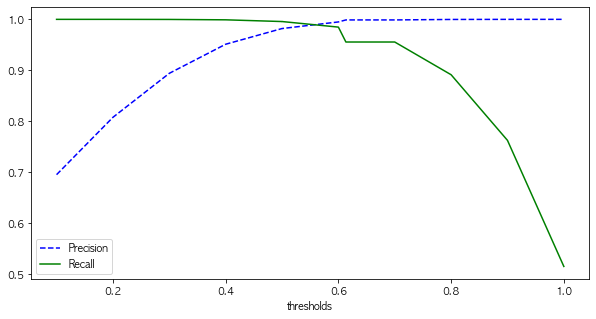

In [25]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

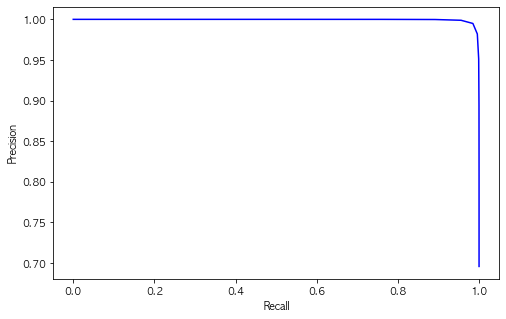

In [26]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [27]:
fpr, tpr, thresholds = roc_curve(train_y, train_y_scores)

Text(0, 0.5, '진짜 양성 비율(TPR, 재현율)')

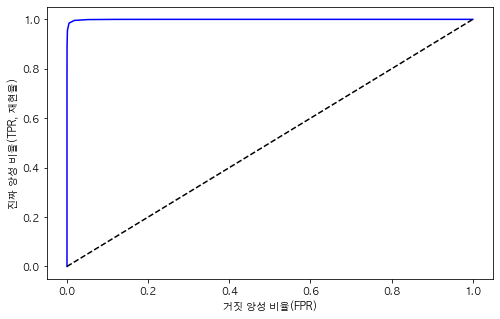

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

In [29]:
# AUC 계산

roc_auc_score(train_y, train_y_scores)

0.9995176666224969

## Test

In [30]:
pred_y = forest_clf.predict(test_x) 

### Confusion matrix

In [31]:
confusion_matrix(test_y, pred_y)

array([[200508,  39839],
       [ 48220, 192126]])

In [32]:
# Accuracy

accuracy_score(test_y, pred_y)

0.8168082331134424

In [33]:
# Precision

precision_score(test_y, pred_y)

0.8282542624964974

In [34]:
# Recall

recall_score(test_y, pred_y)

0.7993725712098392

In [35]:
# F1 Score

f1_score(test_y, pred_y)

0.8135571688993056

### Precision  recall curve 

In [36]:
y_scores = forest_clf.predict_proba(test_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)
len(precisions), len(recalls), len(thresholds)

(19, 19, 18)

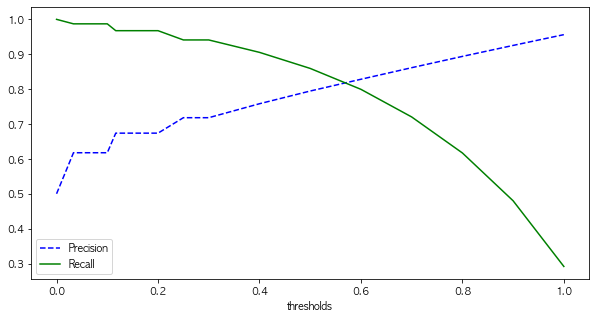

In [37]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

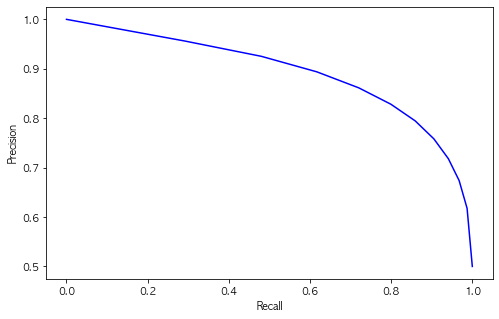

In [38]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [39]:
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

(0.0, 1.0)

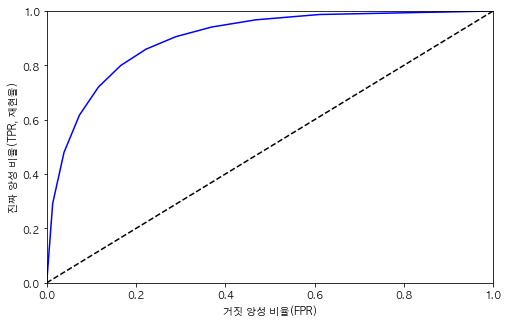

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
plt.xlim((0, 1))
plt.ylim((0, 1))

In [41]:
# AUC 계산

roc_auc_score(test_y, y_scores)

0.8973489509456418

## Feature Importance

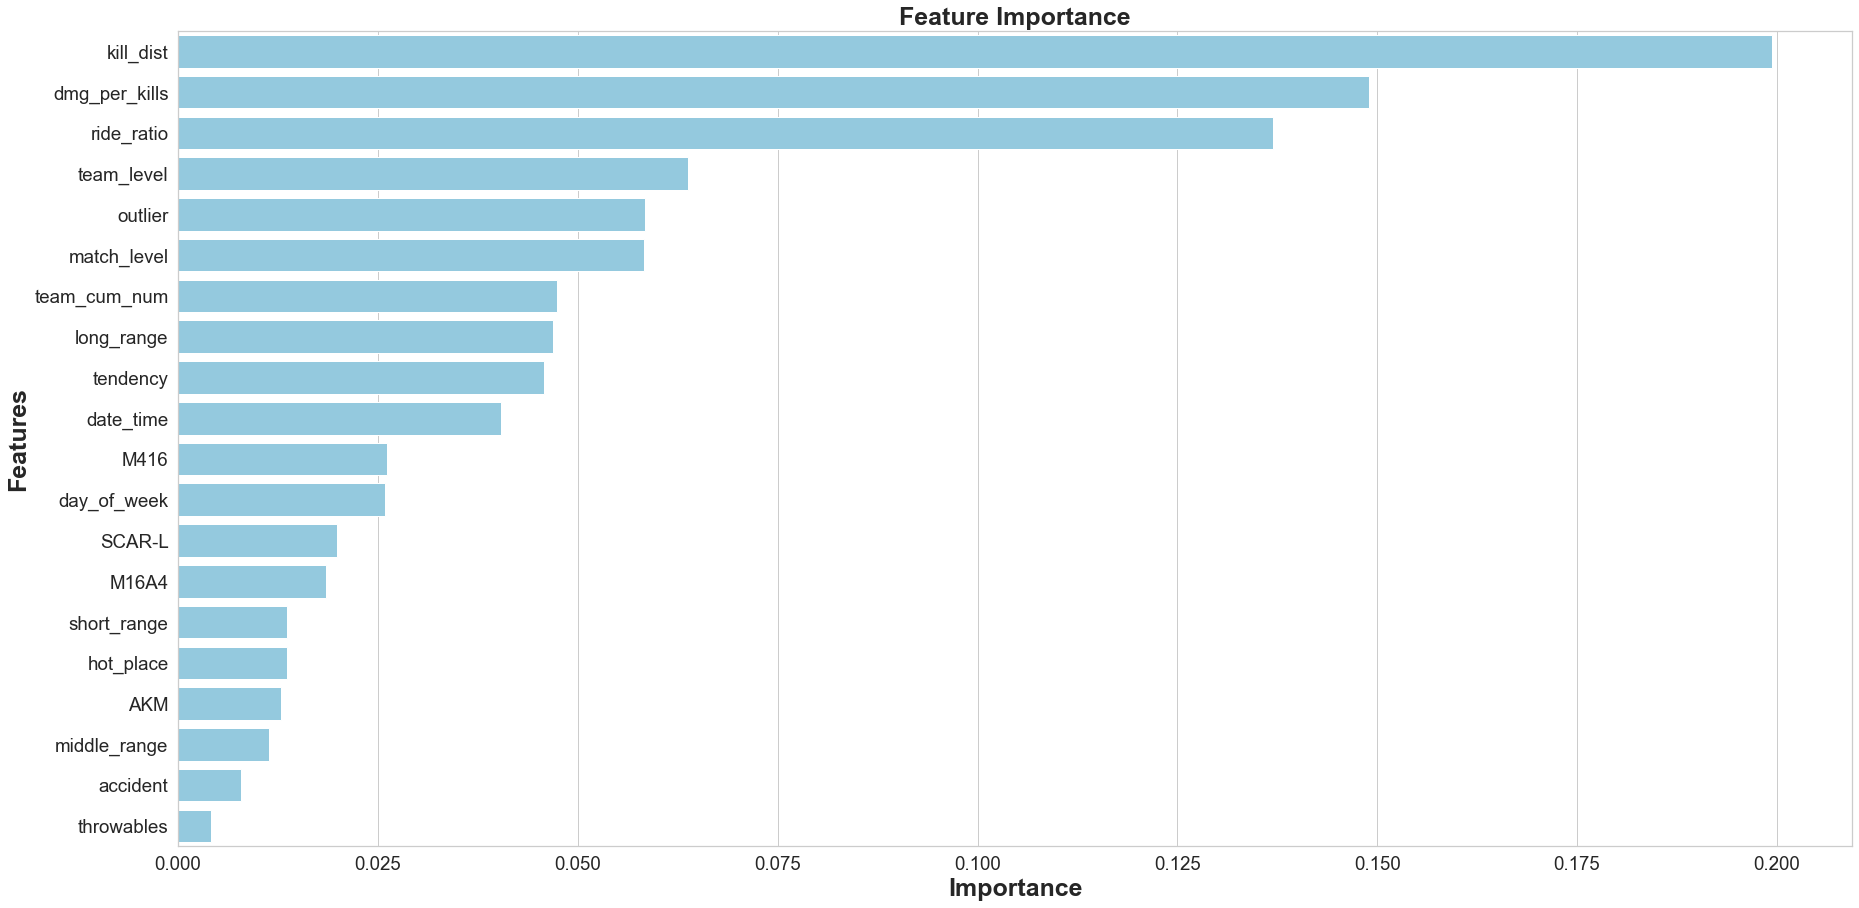

None

,Features,Gini-Importance
0,kill_dist,0.199
1,dmg_per_kills,0.149
2,ride_ratio,0.137
3,team_level,0.064
4,outlier,0.058
5,match_level,0.058
6,team_cum_num,0.047
7,long_range,0.047
8,tendency,0.046
9,date_time,0.040


In [43]:
feats = {}
for feature, importance in zip(X_new.columns.tolist(), forest_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index' : 'Features'})
sns.set(font_scale=5)
sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Feature Importance', fontsize=25, weight='bold')
display(plt.show())
display(importances)

## Cross validate

In [44]:
cv_pred_y = cross_val_predict(forest_clf, train_x, train_y, cv=3)

In [45]:
y_probas_forest = cross_val_predict(forest_clf, train_x, train_y, cv=3, method='predict_proba')

In [46]:
cross_val_score(forest_clf, train_x, train_y, cv=3, scoring='accuracy')

array([0.81696142, 0.81694537, 0.8167523 ])

In [47]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(cv_pred_y, y_scores_forest)

Text(0.5, 1.0, 'ROC Curve 비교')

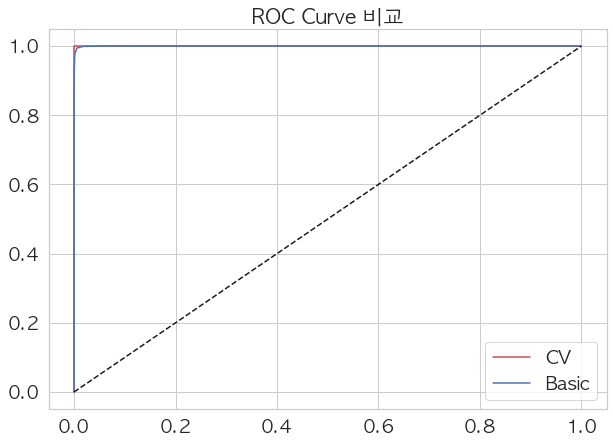

In [100]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_forest, tpr_forest, 'r-', label='CV')
plt.plot(fpr, tpr, 'b-', label='Basic')
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.title('ROC Curve 비교')

## 비교

### Train

In [49]:
confusion_matrix(train_y, pred_train_y)

array([[557993,   2814],
       [  8523, 552285]])

In [50]:
accuracy_score(train_y, train_y_scores)
roc_auc_score(train_y, train_y_scores)

NameError: name 'y_train_scores' is not defined

### Test

In [ ]:
confusion_matrix(test_y, pred_y)

In [ ]:
accuracy_score(test_y, y_scores)
roc_auc_score(test_y, y_scores)

### CV_train

In [ ]:
confusion_matrix(train_y, cv_pred_y)

In [ ]:
accuracy_score(train_y, y_scores_forest)
roc_auc_score(train_y, y_scores_forest)

# Modeling2 - data size 줄이기(50%)

In [51]:
weapon = ['M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
          'accident','throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'each_game_score', 'outlier', 'dmg_per_kills']

In [52]:
X = df_t[['day_of_week', 'date_time'] 
         + ['match_level', 'team_level', 'team_cum_num', 'outlier', 'dmg_per_kills', 'hot_place']
         + ['kill_dist', 'tendency', 'ride_ratio'] 
         + weapon]

In [54]:
Y = df_t['top10']

## Data for Modeling

In [55]:
Y.value_counts()

0.000    6365210
1.000     801154
Name: top10, dtype: int64

In [67]:
idx_0 = list(Y[Y == 0].sample(frac=0.5).index)
idx_1 = list(Y[Y == 1].sample(frac=0.5).index)

In [68]:
X_2 = X.loc[idx_0 + idx_1]
Y_2 = Y.loc[idx_0 + idx_1]

### train/test dataset

In [70]:
train_x, test_x, train_y, test_y = train_test_split(X_2, Y_2, test_size=0.3, random_state=42, stratify=Y_2)

In [71]:
train_y.value_counts(normalize=True)

0.000   0.888
1.000   0.112
Name: top10, dtype: float64

In [72]:
test_y.value_counts(normalize=True)

0.000   0.888
1.000   0.112
Name: top10, dtype: float64

## Model fitting

In [76]:
forest_clf2 = RandomForestClassifier(random_state=42, n_estimators=10)

In [80]:
forest_clf2.fit(train_x, train_y)

RandomForestClassifier(n_estimators=10, random_state=42)

## Train

In [109]:
pred_train_y = forest_clf2.predict(train_x) 

### Confusion matrix

In [110]:
confusion_matrix(train_y, pred_train_y)

array([[2227149,     674],
       [  21423,  258981]])

In [111]:
# Accuracy

accuracy_score(train_y, pred_train_y)

0.9911901913184094

In [112]:
# Precision

precision_score(train_y, pred_train_y)

0.9974042479443878

In [113]:
# Recall

recall_score(train_y, pred_train_y)

0.9235995206915736

In [114]:
# F1 score
f1_score(train_y, pred_train_y)

0.9590841000705479

### Precision recall curve

In [115]:
train_y_scores = forest_clf2.predict_proba(train_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(train_y, train_y_scores)
len(precisions), len(recalls), len(thresholds)

(21, 21, 20)

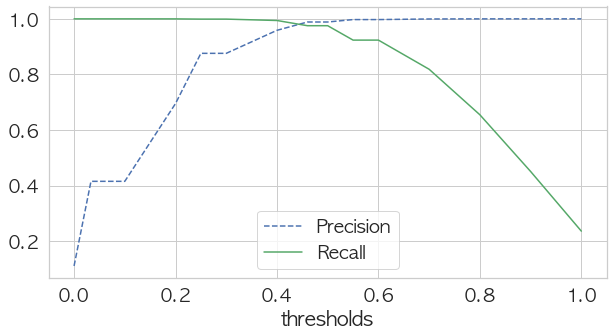

In [116]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

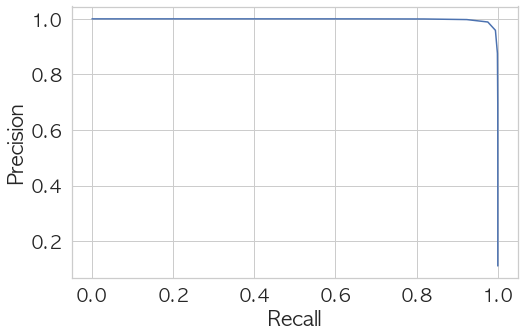

In [117]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [118]:
fpr, tpr, thresholds = roc_curve(train_y, train_y_scores)

Text(0, 0.5, '진짜 양성 비율(TPR, 재현율)')

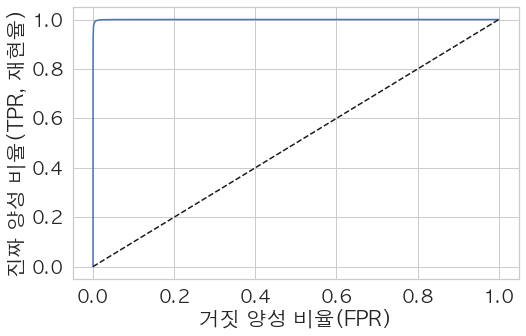

In [92]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

In [119]:
# AUC 계산

roc_auc_score(train_y, train_y_scores)

0.9997650828312856

## TEST

In [120]:
pred_y = forest_clf2.predict(test_x) 

### Confusion matrix

In [121]:
confusion_matrix(test_y, pred_y)

array([[937841,  16941],
       [ 71224,  48949]])

In [122]:
# Accuracy
accuracy_score(test_y, pred_y)

0.9179826132256699

In [123]:
# Precision

precision_score(test_y, pred_y)

0.7428896645925026

In [124]:
# Recall

recall_score(test_y, pred_y)

0.40732111206344185

In [125]:
# F1 Score

f1_score(test_y, pred_y)

0.526155119502534

### Precision recall curve

In [126]:
y_scores = forest_clf2.predict_proba(test_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)
len(precisions), len(recalls), len(thresholds)

(18, 18, 17)

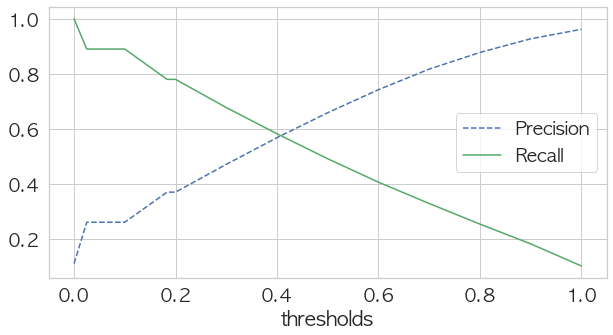

In [127]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

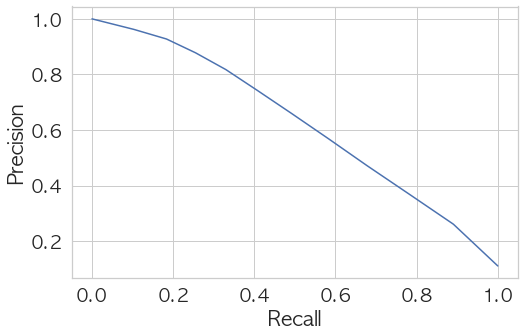

In [128]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [129]:
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

(0.0, 1.0)

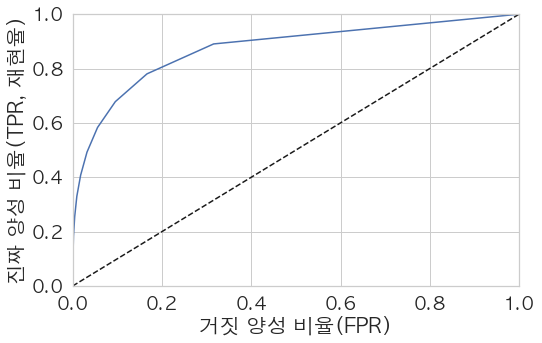

In [130]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
plt.xlim((0, 1))
plt.ylim((0, 1))

In [131]:
# AUC 계산

roc_auc_score(test_y, y_scores)

0.8728318472248207

## Feature importance

In [ ]:
feats = {}
for feature, importance in zip(X_2.columns.tolist(), forest_clf2.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index' : 'Features'})
sns.set(font_scale=5)
sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Feature Importance', fontsize=25, weight='bold')
display(plt.show())
display(importances)

## Cross validate

### Train

In [132]:
cv_pred_y = cross_val_predict(forest_clf2, train_x, train_y, cv=3)

In [133]:
y_probas_forest = cross_val_predict(forest_clf2, train_x, train_y, cv=3, method='predict_proba')

In [134]:
cross_val_score(forest_clf2, train_x, train_y, cv=3, scoring='accuracy')

array([0.91787828, 0.91793091, 0.91811261])

In [135]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(cv_pred_y, y_scores_forest)

Text(0.5, 1.0, 'ROC Curve 비교')

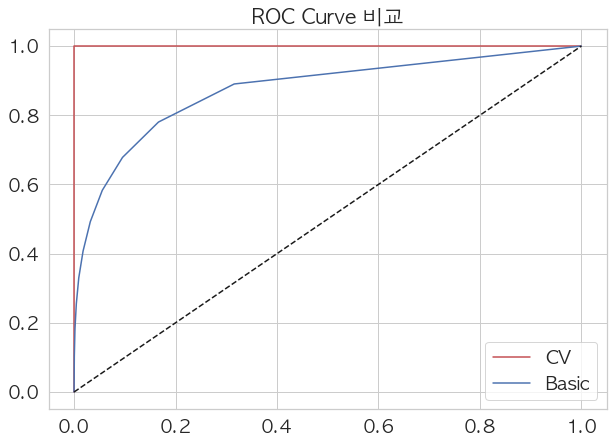

In [136]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_forest, tpr_forest, 'r-', label='CV')
plt.plot(fpr, tpr, 'b-', label='Basic')
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.title('ROC Curve 비교')

### Test

In [145]:
cv_pred_y = cross_val_predict(forest_clf2, test_x, test_y, cv=3)

In [146]:
y_probas_forest = cross_val_predict(forest_clf2, test_x, test_y, cv=3, method='predict_proba')

In [147]:
cross_val_score(forest_clf2, test_x, test_y, cv=3, scoring='accuracy')

array([0.91748414, 0.916789  , 0.91728855])

In [148]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(cv_pred_y, y_scores_forest)

Text(0.5, 1.0, 'ROC Curve 비교')

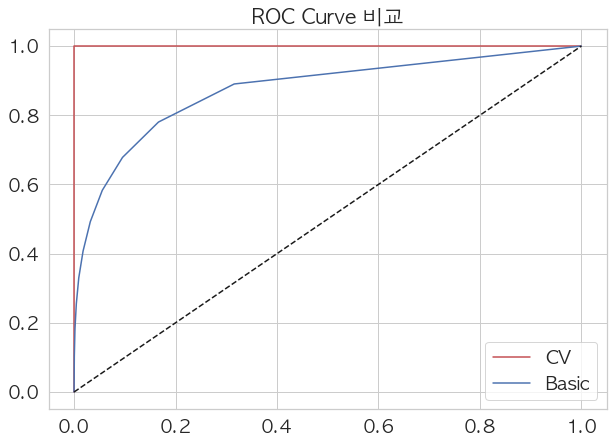

In [149]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_forest, tpr_forest, 'r-', label='CV')
plt.plot(fpr, tpr, 'b-', label='Basic')
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.title('ROC Curve 비교')

## 비교

### Train

In [137]:
confusion_matrix(train_y, pred_train_y)

array([[2227149,     674],
       [  21423,  258981]])

In [139]:
accuracy_score(train_y, pred_train_y)
roc_auc_score(train_y, train_y_scores)

0.9997650828312856

### Test

In [141]:
confusion_matrix(test_y, pred_y)

array([[937841,  16941],
       [ 71224,  48949]])

In [140]:
accuracy_score(test_y, pred_y)
roc_auc_score(test_y, y_scores)

0.8728318472248207

### CV_Train

In [151]:
confusion_matrix(train_y, cv_pred_y)

array([[938309,  16473],
       [ 72547,  47626]])

In [152]:
accuracy_score(train_y, cv_pred_y)
roc_auc_score(train_y, y_scores_forest)

0.8710817192452558

### CV_Test

In [153]:
confusion_matrix(test_y, cv_pred_y)

array([[938309,  16473],
       [ 72547,  47626]])

In [154]:
accuracy_score(test_y, cv_pred_y)
roc_auc_score(test_y, y_scores_forest)

0.8710817192452558

# Modeling3 - data size 줄이기(70%)

In [155]:
weapon = ['M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
          'accident','throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'each_game_score', 'outlier', 'dmg_per_kills']

X = df_t[['day_of_week', 'date_time'] 
         + ['match_level', 'team_level', 'team_cum_num', 'outlier', 'dmg_per_kills', 'hot_place']
         + ['kill_dist', 'tendency', 'ride_ratio'] 
         + weapon]

Y = df_t['top10']

## Data for Modeling

In [156]:
Y.value_counts()

0.000    6365210
1.000     801154
Name: top10, dtype: int64

In [158]:
idx_0 = list(Y[Y == 0].sample(frac=0.7).index)
idx_1 = list(Y[Y == 1].sample(frac=0.7).index)

In [160]:
X_3 = X.loc[idx_0 + idx_1]
Y_3 = Y.loc[idx_0 + idx_1]

### train/test dataset

In [161]:
train_x, test_x, train_y, test_y = train_test_split(X_3, Y_3, test_size=0.3, random_state=42, stratify=Y_3)

In [162]:
train_y.value_counts(normalize=True)

0.000   0.888
1.000   0.112
Name: top10, dtype: float64

In [163]:
test_y.value_counts(normalize=True)

0.000   0.888
1.000   0.112
Name: top10, dtype: float64

## Model fitting

In [165]:
forest_clf3 = RandomForestClassifier(random_state=42, n_estimators=10)

In [166]:
forest_clf3.fit(train_x, train_y)

RandomForestClassifier(n_estimators=10, random_state=42)

## Train

In [167]:
pred_train_y = forest_clf3.predict(train_x) 

### Confusion matrix

In [168]:
confusion_matrix(train_y, pred_train_y)

array([[3118018,     934],
       [  29925,  362641]])

In [169]:
# Accuracy

accuracy_score(train_y, pred_train_y)

0.9912120627033665

In [170]:
# Precision

precision_score(train_y, pred_train_y)

0.9974310664924706

In [171]:
# Recall

recall_score(train_y, pred_train_y)

0.9237707799452831

In [173]:
# F1 score

f1_score(train_y, pred_train_y)

0.9591888285385927

### Precision recall curve

In [174]:
train_y_scores = forest_clf3.predict_proba(train_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(train_y, train_y_scores)
len(precisions), len(recalls), len(thresholds)

(20, 20, 19)

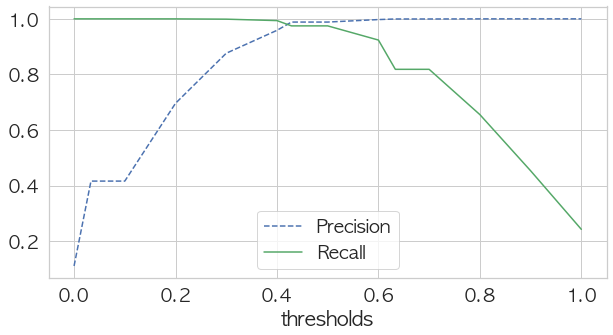

In [175]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

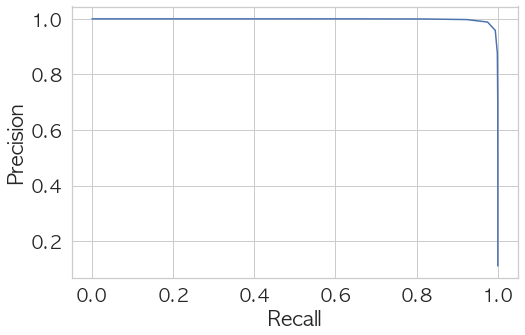

In [176]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [177]:
fpr, tpr, thresholds = roc_curve(train_y, train_y_scores)

Text(0, 0.5, '진짜 양성 비율(TPR, 재현율)')

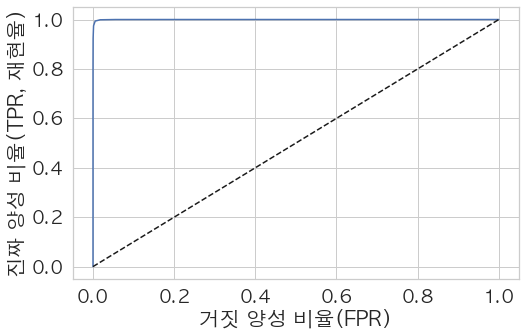

In [178]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

In [179]:
# AUC 계산

roc_auc_score(train_y, train_y_scores)

0.9997573615784195

## TEST

In [180]:
pred_y = forest_clf2.predict(test_x) 

### Confusion matrix

In [181]:
confusion_matrix(test_y, pred_y)

array([[1321165,   15530],
       [  69040,   99202]])

In [182]:
# Accuracy

accuracy_score(test_y, pred_y)

0.9438049566194465

In [183]:
# Precision

precision_score(test_y, pred_y)

0.8646410765958931

In [184]:
# Recall

recall_score(test_y, pred_y)

0.5896387346798064

In [185]:
# F1 Score

f1_score(test_y, pred_y)

0.7011386205093046

### Precision recall curve

In [189]:
y_scores = forest_clf3.predict_proba(test_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)
len(precisions), len(recalls), len(thresholds)

(16, 16, 15)

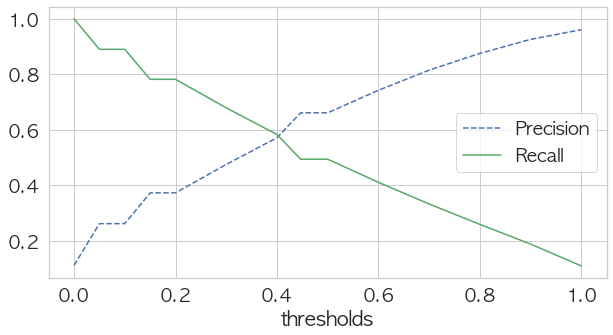

In [190]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

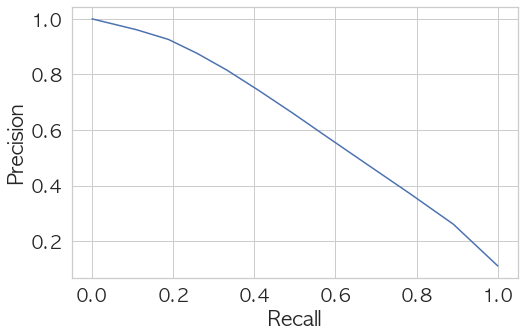

In [191]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [192]:
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

(0.0, 1.0)

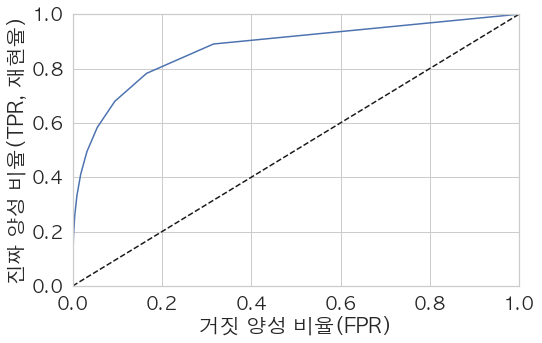

In [193]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
plt.xlim((0, 1))
plt.ylim((0, 1))

In [194]:
# AUC 계산

roc_auc_score(test_y, y_scores)

0.8733867019527413

## Feature importance

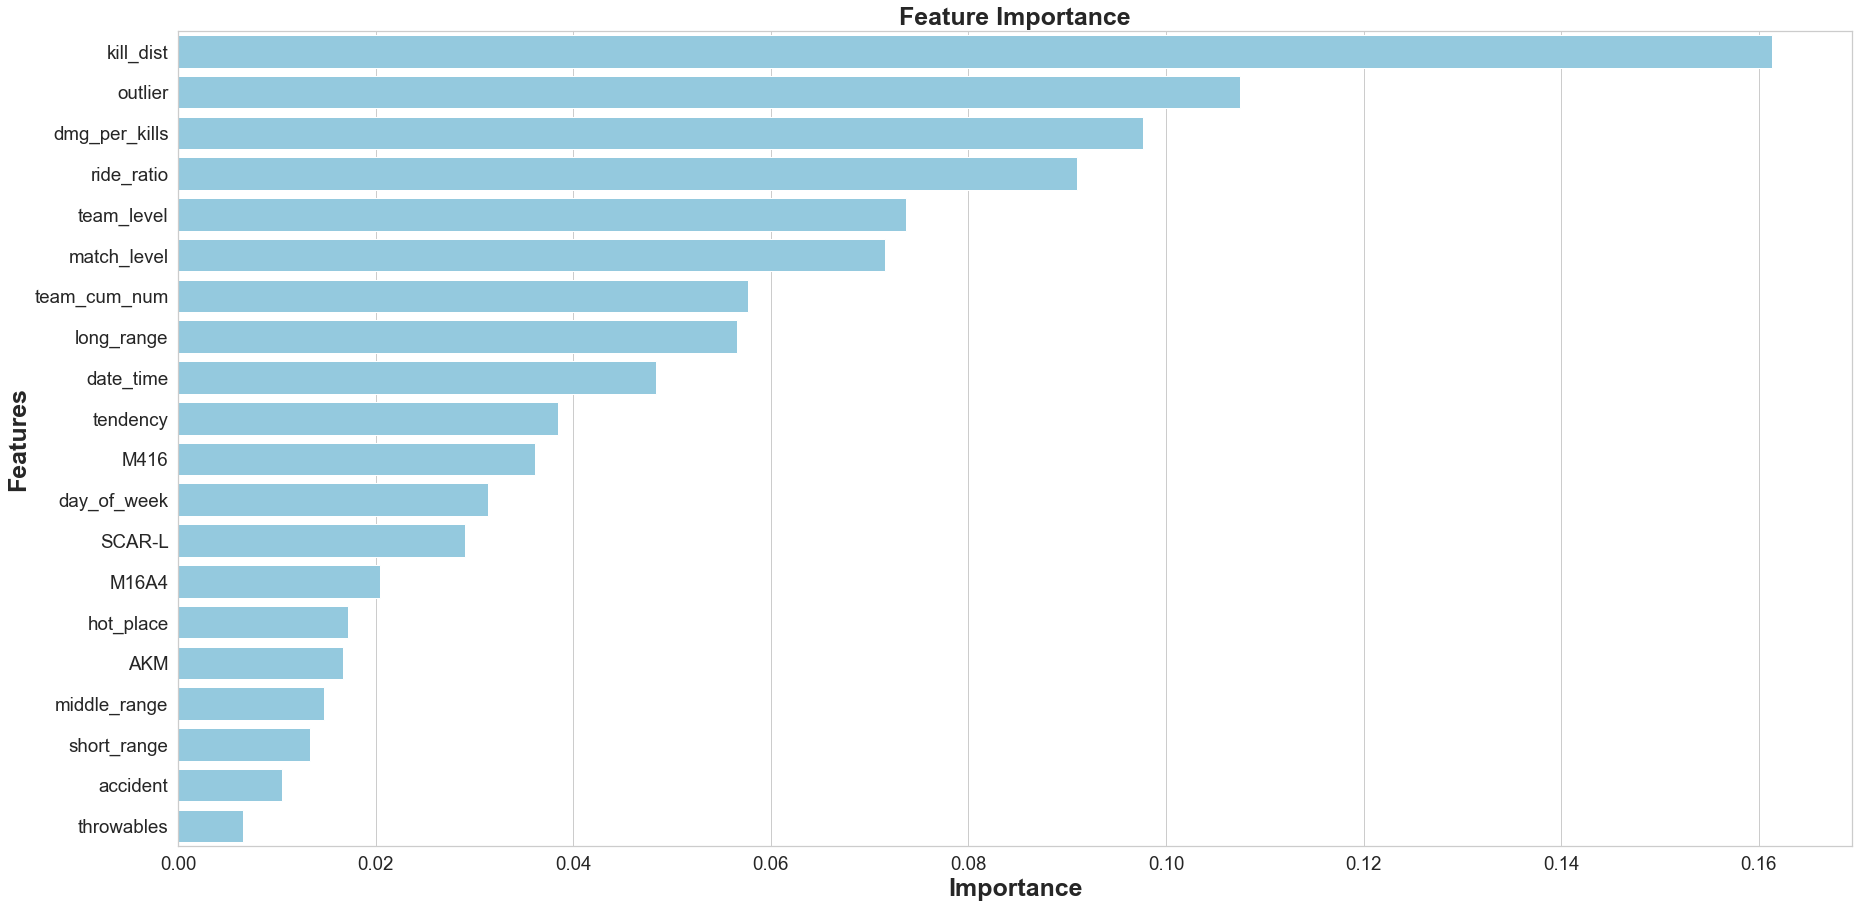

None

,Features,Gini-Importance
0,kill_dist,0.161
1,outlier,0.107
2,dmg_per_kills,0.098
3,ride_ratio,0.091
4,team_level,0.074
5,match_level,0.072
6,team_cum_num,0.058
7,long_range,0.057
8,date_time,0.048
9,tendency,0.038


In [203]:
feats = {}
for feature, importance in zip(X_3.columns.tolist(), forest_clf3.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index' : 'Features'})
sns.set(font_scale=5)
sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Feature Importance', fontsize=25, weight='bold')
display(plt.show())
display(importances)

## Cross validate

### Train

In [197]:
cv_pred_y = cross_val_predict(forest_clf3, train_x, train_y, cv=3)

In [198]:
y_probas_forest = cross_val_predict(forest_clf3, train_x, train_y, cv=3, method='predict_proba')

In [199]:
cross_val_score(forest_clf3, train_x, train_y, cv=3, scoring='accuracy')

array([0.91786031, 0.91855232, 0.91822682])

In [200]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(cv_pred_y, y_scores_forest)

Text(0.5, 1.0, 'ROC Curve 비교')

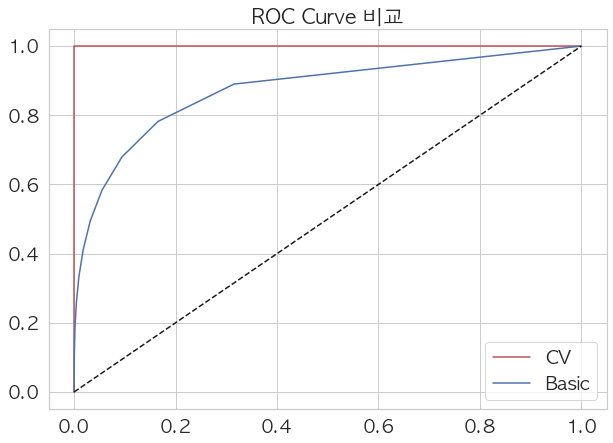

In [205]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_forest, tpr_forest, 'r-', label='CV')
plt.plot(fpr, tpr, 'b-', label='Basic')
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.title('ROC Curve 비교')

### Test

In [206]:
cv_pred_y = cross_val_predict(forest_clf3, test_x, test_y, cv=3)

In [207]:
y_probas_forest = cross_val_predict(forest_clf3, test_x, test_y, cv=3, method='predict_proba')

In [208]:
cross_val_score(forest_clf3, test_x, test_y, cv=3, scoring='accuracy')

array([0.916768  , 0.91767501, 0.91721636])

In [209]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(cv_pred_y, y_scores_forest)

Text(0.5, 1.0, 'ROC Curve 비교')

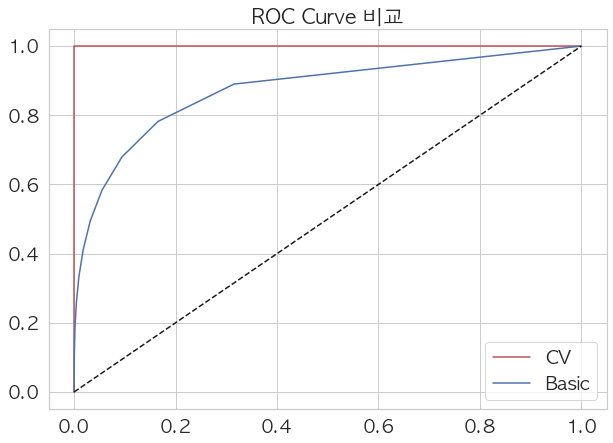

In [210]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_forest, tpr_forest, 'r-', label='CV')
plt.plot(fpr, tpr, 'b-', label='Basic')
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend()
plt.title('ROC Curve 비교')

## 비교

### Train

In [211]:
confusion_matrix(train_y, pred_train_y)

array([[3118018,     934],
       [  29925,  362641]])

In [212]:
accuracy_score(train_y, pred_train_y)
roc_auc_score(train_y, train_y_scores)

0.9997573615784195

### Test

In [213]:
confusion_matrix(test_y, pred_y)

array([[1321165,   15530],
       [  69040,   99202]])

In [214]:
accuracy_score(test_y, pred_y)
roc_auc_score(test_y, y_scores)

0.8733867019527413

### CV_Train

In [217]:
confusion_matrix(train_y, cv_pred_y)

ValueError: Found input variables with inconsistent numbers of samples: [3511518, 1504937]

In [216]:
accuracy_score(train_y, cv_pred_y)
roc_auc_score(train_y, y_scores_forest)

ValueError: Found input variables with inconsistent numbers of samples: [3511518, 1504937]

### CV_Test

In [218]:
confusion_matrix(test_y, cv_pred_y)

array([[1313268,   23427],
       [ 101152,   67090]])

In [219]:
accuracy_score(test_y, cv_pred_y)
roc_auc_score(test_y, y_scores_forest)

0.8716768779567192